Style GAN

In [1]:
#import stuff
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, LeakyReLU, AveragePooling2D, Add, Input, InputSpec, UpSampling2D, Activation, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import backend as K
from tensorflow.python.keras.utils import conv_utils
import matplotlib.pyplot as plt
import numpy as np

Parameters

In [2]:
batch_size = 32
depth = 32
latent_size = 512

Load and process the data

In [ ]:
#load raw data
raw_ds = tf.keras.preprocessing.image_dataset_from_directory('D:\Datasets\keras_png_slices_data\keras_png_slices_train', labels=None, color_mode='grayscale', batch_size=batch_size)
print(raw_ds)

#check range of values in raw data
image_batch = next(iter(raw_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

#normalise the data
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
norm_ds = raw_ds.map(lambda img: (normalization_layer(img)))

#check range of values in raw data
image_batch = next(iter(norm_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


In [ ]:
#visualise raw data
for images in raw_ds.take(1):
    plt.imshow(images[0].numpy().astype("float32"), cmap='gray')
    plt.show()

In [ ]:
#visualise norm data
for images in norm_ds.take(1):
    plt.imshow(images[0].numpy().astype("float32"), cmap='gray')
    plt.show()

Networks

In [3]:
#Conv2DMod layer
#https://github.com/manicman1999/StyleGAN2-Tensorflow-2.0/blob/989306792ca49dcbebb353c4f06c7b48aeb3a9e3/conv_mod.py#L15

class ModConv2D (keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=(1,1), padding = 'valid', kernel_initializer='glorot_uniform', 
                    kernel_regularizer=None, activity_regularizer=None, kernel_constraint=None, demod = True, **kwargs):
        #define all the parameters of the layer
        super(ModConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.rank = 2
        self.kernel_size= conv_utils.normalize_tuple(kernel_size, 2, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, 2, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        #?
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        #?
        self.demod = demod

        #input with ndim=4 is previous convolution layer
        #input with ndim=2 is the input style for this layer (output from style generator)
        self.Input_spec = [InputSpec(ndim=4), InputSpec(ndim=2)]


    def build(self, input_shape):
        #define weights after shape of input is known
        channel_axis = -1
        input_dim = input_shape[0][channel_axis] #should be 1 for this dataset since it's only grayscale images being sent through the system
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape, initializer=self.kernel_initializer, name='kernel', 
                                        regularizer=self.kernel_regularizer, constraint=self.kernel_constraint)

        #input specifications
        #input_shape[0] is the output of the previous layer
        #input_shape[1] is the style
        self.input_spec = [InputSpec(ndim=4, axes={channel_axis: input_dim}), InputSpec(ndim=2)]

        self.built = True


    def call(self, inputs):
        #execute the code when the layer is used
            #modulation stuff
        style = inputs[1]
        #print("style shape:", style.shape)
        #print("kernel shape:", self.kernel.shape)

        #make the input style W shape compatible with kernel
        inp_mods = K.expand_dims(K.expand_dims(style, axis = 1), axis = 1)
        my_kernel = K.expand_dims(self.kernel, axis=0)

        #modulate
        #print("kernel", (int)(tf.rank(my_kernel)), my_kernel.shape)
        #print("kernel shape:", my_kernel.shape)
        #print("input style", (int)(tf.rank(inp_mods)), inp_mods.shape)
        #print("input style shape:", inp_mods.shape)
        weights = my_kernel * (inp_mods + 1)
        #weights = 0

        #demodulate
        if self.demod:
            weights /= K.sqrt(K.sum(K.square(weights), axis=[1,2,3], keepdims = True) + 1e-8)
        
        x = tf.transpose(inputs[0], [0,3,1,2])
        x = tf.reshape(x, [1, -1, x.shape[2], x.shape[3]])

        w = tf.transpose(weights, [1,2,3,0,4])
        w = tf.reshape(w, [weights.shape[1], weights.shape[2], weights.shape[3], -1])

        #normal convolution 2d
        #data is stored in [batch_size, channels, height, width]
        x = tf.nn.conv2d(x, w, strides=self.strides, padding='SAME', data_format='NCHW')

        #print(x.shape)

        x = tf.reshape(x, [-1, self.filters, tf.shape(x)[2], tf.shape(x)[3]]) # Fused => reshape convolution groups back to minibatch.
        x = tf.transpose(x, [0, 2, 3, 1])

        return x

In [4]:
#define generator
#mapping network
    #for taking an image (style) and converting it to latent space to use in the weights of the synthesis network
#synthesis network
    #network used to generate images using input style and noise
    #skip connections

#https://github.com/manicman1999/StyleGAN2-Tensorflow-2.0/blob/master/stylegan_two.py

def crop_to_fit(x):
    #makes sure that x[0] has the same dimensions as x[1]
    height = x[1].shape[1]
    width = x[1].shape[2]

    return x[0][:, :height, :width, :]

def make_style_generator():
    #standard deep NN
    model = tf.keras.Sequential()
    model.add(Dense(512, input_shape=[1, latent_size]))
    model.add(LeakyReLU(0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))

    return model


def g_block(inputs, input_style, input_noise, filters, upsampling=True):

    #optional upsampling
    if upsampling:
        out = UpSampling2D(interpolation='bilinear')(inputs)
    else:
        out = Activation('linear')(inputs)


    #main block
    #style stuff
    style = Dense(filters, kernel_initializer = VarianceScaling(200/out.shape[2]))(input_style)
    delta = Lambda(crop_to_fit)([input_noise, out])
    d = Dense(filters, kernel_initializer='zeros')(delta)

    #ModConv2D block
    out = ModConv2D(filters, (3,3), strides=(1,1), padding="same", kernel_initializer = 'he_uniform')([out, style])
    out = Add()([out, d])
    out = LeakyReLU(0.2)(out)

    return out

def make_generator_model ():
    #constant input
    ''' inputs = Input(shape=[[512,1],[64,64,1]])
    input_style = inputs[0]
    input_noise = inputs[1] '''
    input_style = Input(shape=(512))
    input_noise = Input(shape=(256, 256, 1))

    x = tf.ones((1, 512))#Lambda(lambda x: x[:, :1]*0 + 1)(input_style) #just a 512 vector of 1s

    x = Dense(4*4*4*depth, activation='relu', kernel_initializer='random_normal')(x)
    x = Reshape([4, 4, 4*depth])(x) #a [4, 4, 4*depth] tensor

    x = g_block(x, input_style, input_noise, 64*depth, upsampling=False)    #4x4
    x = g_block(x, input_style, input_noise, 32*depth)                      #8x8
    x = g_block(x, input_style, input_noise, 16*depth)                      #16x16
    #x = g_block(x, input_style, input_noise, 8*depth)                       #32x32
    #x = g_block(x, input_style, input_noise, 4*depth)                       #64x64
    #x = g_block(x, input_style, input_noise, 2*depth)                       #128x128
    #x = g_block(x, input_style, input_noise, depth)                         #256x256

    model = Model(inputs = [input_style, input_noise], outputs = x)
    return model

In [5]:
style_generator = make_style_generator()
style_generator.summary()

style_vector = style_generator(tf.random.normal((1,512)))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 512)            262656    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1, 512)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 512)            262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 512)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 512)            262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1, 512)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1, 512)            2

In [10]:
#create generator
generator = make_generator_model()
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 2048)         1050624     input_3[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 4, 4, 1)      0           input_4[0][0]                    
____________________________________________________________________________________________

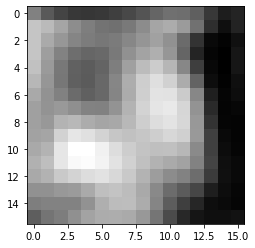

In [13]:
noise = tf.random.normal((256,256,1))
generated_image = generator((style_vector, noise))

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
#define discriminator
    #residual connections

#https://github.com/manicman1999/StyleGAN2-Tensorflow-2.0/blob/master/stylegan_two.py

def d_block(inputs, filters, pooling=True):
    residual = Conv2D(filters, 1)(inputs)

    out = Conv2D(filters, (3,3), padding='same')(inputs)
    out = LeakyReLU(0.2)(out)
    out = Conv2D(filters, (3,3), padding='same')(out)
    out = LeakyReLU(0.2)(out)

    out = Add()([residual, out])

    if pooling:
        out = AveragePooling2D()(out)

    return out

def make_discriminator_model():
    inputs = Input(shape=(256, 256, 1))

    x = d_block(inputs, depth)
    x = d_block(x, depth * 2)
    x = d_block(x, depth * 4)
    x = d_block(x, depth * 8)
    x = d_block(x, depth * 16, pooling=False)

    #classification stuff
    x = Flatten()(x)
    x = Dense(1)(x)

    model = Model(inputs= inputs, outputs = x)

    return model

In [ ]:
#create discriminator
discriminator = make_discriminator_model()
discriminator.summary()

Training

In [ ]:
#define training step

In [ ]:
#define training loop

In [ ]:
#run training loop

Visualise outcome

In [ ]:
#losses and inference